# SHAP and complicated regressions

This notebook explains how to interpret a complicated linear regression with SHAP.

In [99]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder
import shap

## Data preparation

In [101]:
# Take a small data set
dat = sm.datasets.get_rdataset("Guerry", "HistData").data

# We will use these covariables
feature_names = ['Literacy', 'MainCity', 'Pop1831']

# "Raw" (unprocessed) dataset used to for neat dependence plots
X_display = dat[feature_names]

# X: same as raw dataset but all covariables represented as numerics
X = X_display.copy()
X['MainCity'] = OrdinalEncoder().fit_transform(X[['MainCity']])

# Xy: same as X but including response for statsmodels regression
Xy = X.copy()
Xy['Lottery'] = dat.Lottery
Xy.head(2)

,Literacy,MainCity,Pop1831,Lottery
0,37,1.0,346.03,41
1,51,1.0,513.00,38


## Complicated regression

In [104]:
fit = smf.ols('Lottery ~ Literacy + I(Literacy**2) + C(MainCity) * np.log(Pop1831)', 
              data=Xy).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     12.63
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           1.02e-10
Time:                        21:49:26   Log-Likelihood:                -365.66
No. Observations:                  86   AIC:                             747.3
Df Residuals:                      78   BIC:                             767.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            214.5179     89.077      2.408      0.018      37.179     391.857
C(MainCity)[T.1.0]                   -73.9021     98.560     -0.750      0.456    -270.121     122.317
C(MainCity)[T.2.0]                  -184.7960    141.992     -1.301      0.197    -467.480      97.888
Literacy                              -0.6878      0.571     -1.205      0.232      -1.824       0.449
I(Literacy ** 2)                       0.0026      0.007      0.397      0.693      -0.011       0.016
np.log(Pop1831)                      -21.7301     16.148     -1.346      0.182     -53.879      10.419
C(MainCity)[T.1.0]:np.log(Pop1831)     8.9890     17.779      0.506      0.615     -26.407      44.385
C(MainCity)[T.2.0]:np.log(Pop1831)    22.3794     23.908      0.936      0.352     -25.217      69.976
==============================================================================
Omnibus:                        0.399   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.819   Jarque-Bera (JB):                0.174
Skew:                          -0.106   Prob(JB):                        0.917
Kurtosis:                       3.061   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## SHAP Kernel explainer

The KernelExplainer in shap converts the input datasets to numpy before calling the predict function. We use a mapping trick outlined in https://github.com/slundberg/shap/issues/179 resp. https://gist.github.com/noleto/05dfa4a691ebbc8816c035b86d2d00d4 
Its idea is to write a predict function that first maps the numeric input to a pandas dataframe with correct names.

In [105]:
# Predict function taking a numeric numpy/pandas input and converts to named pandas DataFrame
def smf_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=feature_names)
    return fit.predict(data_asframe)

explainer = shap.KernelExplainer(smf_predict, X)
shap_values = explainer.shap_values(X)
shap_values.shape

  0%|          | 0/86 [00:00<?, ?it/s]

(86, 3)

### Variable importance

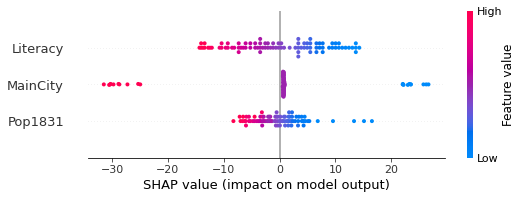

In [106]:
shap.summary_plot(shap_values, X)

### Dependence plots

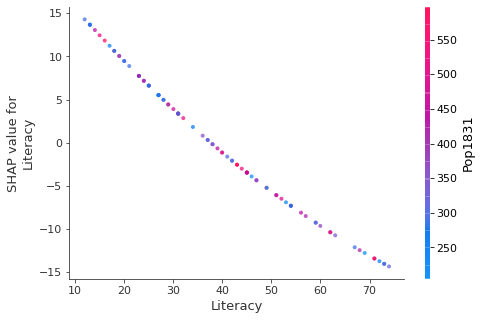

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


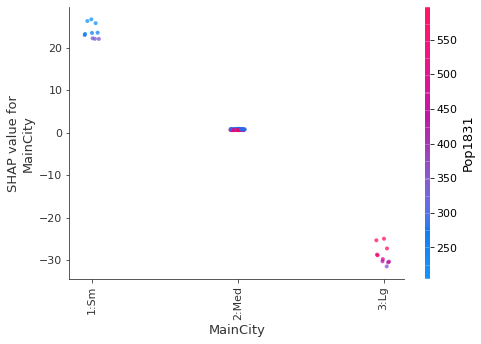

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


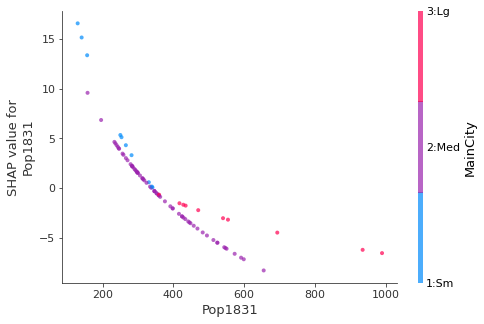

In [111]:
for f in feature_names:
    shap.dependence_plot(f, shap_values, X, display_features=X_display, 
                         alpha=0.7, x_jitter=0.1);